<a href="https://www.canva.com/design/DAFfKJ-tBmY/MaBo1RIoh_CA5DcvWNox2Q/view?utm_content=DAFfKJ-tBmY&utm_campaign=designshare&utm_medium=link&utm_source=publishsharelink">Regression Modeling Slides</a>
### Prepare Data for Modeling

## **Wrangle**

1. Acquired data from student-mat.csv. 

2. Create dummy vars

3. Split data 

4. Scale data

wrangle.wrangle_student_math(path) returns the following: 

| Object Returned | Description | Purpose                          |
|:-------------------|:--------------------------------|:----------------------------------------------------|
| 1. df | **Dataframe**, **Feature** and **target** variables, **Unscaled**, Dummy vars **with** original categorical vars | New features, additional cleaning needed, etc. |
| 2. X_train_exp | **Dataframe**, **Feature** variables only, **Unscaled**, Dummy vars **with** original categorical vars | Exploration & analysis     |
| 3. X_train | **Dataframe**, **Feature** variables only, **Scaled**, Dummy vars **without** original categorical vars | Feature selection, fit models, make predictions |
| 4. y_train | **Series**, **Target** variable only, **Unscaled** | Feature selection, evaluate model predictions |
| 5. X_validate | **Dataframe**, **Features** variables only, **Scaled**, Dummy vars **without** original categorical vars | Make predictions using top models |
| 6. y_validate | **Series**, **Target** variable only, **Unscaled** | Evaluate model predictions made from X_validate to assess overfitting | 
| 7. X_test | **Dataframe**, **Features** variables only, **Scaled**, Dummy vars **without** original categorical vars | Make predictions using best model|
| 8. y_test | **Series**, **Target** variable only, **Unscaled** | Evaluate model predictions made from X_test to estimate future performance on new data |

In [1]:
import pandas as pd
import numpy as np
import wrangle_model
import matplotlib.pyplot as plt

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
path='https://gist.githubusercontent.com/ryanorsinger/55ccfd2f7820af169baea5aad3a9c60d/raw/da6c5a33307ed7ee207bd119d3361062a1d1c07e/student-mat.csv'

In [3]:
df, \
X_train_exp, \
X_train, \
y_train, \
X_validate, \
y_validate, \
X_test, \
y_test = wrangle_model.wrangle_student_math(path)

In [4]:
# Check how many observations and features we have in each dataframe

print(f"""Train shape: {X_train.shape}
Validate shape: {X_validate.shape}
Test shape: {X_test.shape}
""")

Train shape: (221, 15)
Validate shape: (95, 15)
Test shape: (79, 15)



In [5]:
# check the X_train head:
X_train.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
142,0.000000,1.00,1.00,0.000000,0.666667,0.000000,0.75,0.25,0.25,0.00,0.00,1.00,0.035714,0.357143,0.578947
326,0.333333,0.75,0.75,0.000000,0.000000,0.000000,0.75,0.50,1.00,0.50,1.00,1.00,0.053571,0.714286,0.789474
88,0.166667,0.50,0.50,0.333333,0.333333,0.333333,0.75,0.75,0.25,0.00,0.00,0.50,0.214286,0.500000,0.526316
118,0.333333,0.25,0.75,0.666667,0.333333,0.333333,1.00,0.25,0.75,0.00,0.75,1.00,0.357143,0.357143,0.368421
312,0.666667,0.25,0.50,0.000000,0.333333,0.333333,0.75,1.00,0.25,0.25,0.25,0.75,0.053571,0.642857,0.578947


In [6]:
# and y_train head:
y_train.head()

142    11
326    16
88     10
118     8
312    11
Name: G3, dtype: int64

### Target Variable/y

This helps us determine which type of algorithm we may want to use. 

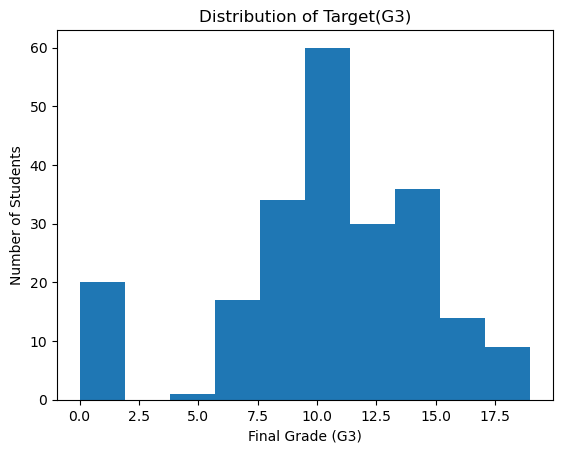

In [7]:
plt.hist(y_train)
plt.title('Distribution of Target(G3)')
plt.xlabel("Final Grade (G3)")
plt.ylabel("Number of Students")

plt.show()

#Fairly Normally Dist.
#There maybe outliers
#May be Bimodal
#-We need more bg on the data

## Modeling

### Baseline

About the initial baseline: 

> Before we begin making models, we need to know how well we can estimate (predict) the final grade (G3) without using any features. This is often done by predicting every observation's target value to be the mean or the median. E.g. we could predict every student's final grade to be the mean final grade of all the students in our training sample. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat. 


1. Predict all final grades to be 10.52, which is equal to the mean of G3 for the training sample. Store in `y_train['G3_pred_mean']`. 

2. Predict all final grades to be 11, which is equal to the median of G3 for the training sample. Store in `y_train['G3_pred_median']`.  

3. Compute the RMSE comparing actual final grade (G3) to G3_pred_mean. 

4. Compute the RMSE comparing actual final grade (G3) to G3_pred_median. 

In [8]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [9]:
# 1. Predict G3_pred_mean
G3_pred_mean = y_train.G3.mean()
y_train['G3_pred_mean'] = G3_pred_mean
y_validate['G3_pred_mean'] = G3_pred_mean

In [10]:
# 2. compute G3_pred_median
G3_pred_median = y_train.G3.median()
y_train['G3_pred_median'] = G3_pred_median
y_validate['G3_pred_median'] = G3_pred_median

In [11]:
# 3. RMSE of G3_pred_mean
rmse_train_mu = mean_squared_error(y_train.G3,
                                y_train.G3_pred_mean) ** .5

rmse_validate_mu = mean_squared_error(y_validate.G3, y_validate.G3_pred_mean) ** (0.5)

print(f"""RMSE using Mean
Train/In-Sample: {round(rmse_train_mu, 2)} 
Validate/Out-of-Sample: {round(rmse_validate_mu, 2)}""")

RMSE using Mean
Train/In-Sample: 4.5 
Validate/Out-of-Sample: 4.58


In [12]:
# 4. RMSE of G3_pred_median
rmse_train_med = mean_squared_error(y_train.G3, y_train.G3_pred_median) ** .5
rmse_validate_med = mean_squared_error(y_validate.G3, y_validate.G3_pred_median) ** (0.5)

print(f"""RMSE using Median
Train/In-Sample: {round(rmse_train_med, 2)} 
Validate/Out-of-Sample: {round(rmse_validate_med, 2)}""")

RMSE using Median
Train/In-Sample: 4.52 
Validate/Out-of-Sample: 4.69



#### Addendum/Note:
we will incrementally build 
a dataframe for comparison of 
our metrics for model selection
for ease of reflection


In [13]:
y_train.head()

,G3,G3_pred_mean,G3_pred_median
142,11,10.524887,11.0
326,16,10.524887,11.0
88,10,10.524887,11.0
118,8,10.524887,11.0
312,11,10.524887,11.0


In [14]:
# Let's house our metrics in a df to later compare

metric_df = pd.DataFrame(data=[
    {'model': 'mean_baseline',
     'RMSE_train': rmse_train_mu,
     'RMSE_validate': rmse_validate_mu,
     'R2_validate': explained_variance_score(y_validate.G3,
                                             y_validate.G3_pred_mean)
    }
]
)

In [15]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,4.498926,4.578917,2.220446e-16


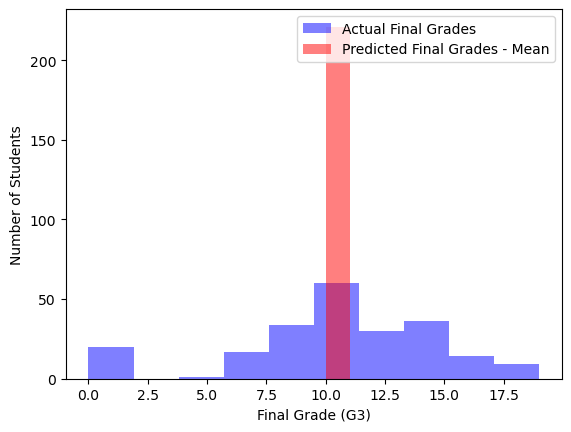

In [16]:
# plot to visualize actual vs predicted. 

plt.hist(y_train.G3, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_train.G3_pred_mean, bins=1, color='red', alpha=.5,  label="Predicted Final Grades - Mean")
#plt.hist(y_train.G3_pred_median, bins=1, color='orange', alpha=.5, label="Predicted Final Grades - Median")
plt.xlabel("Final Grade (G3)")
plt.ylabel("Number of Students")
plt.legend()
plt.show()

___ 
### LinearRegression (OLS)

1. Fit the model using `X_train` (scaled) and the labels from `y_train`. 

2. Predict final grade `G3` for students in training sample using our model (lm). 

3. Evaluate using RMSE

4. **Repeat** predictions and evaluation for `validation`. 

5. **Compare** RMSE `train` vs. `validation`. 
    - Overfitting? 

In [17]:
# MAKE THE THING: create the model object
lm = LinearRegression()

#1. FIT THE THING: fit the model to training data
OLSmodel = lm.fit(X_train, y_train.G3)

#2. USE THE THING: make a prediction
y_train['G3_pred_lm'] = lm.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lm)**(1/2)


In [18]:
#4. REPEAT STEPS 2-3

# predict validate
y_validate['G3_pred_lm'] = lm.predict(X_validate)


# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lm)**(1/2)


print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}""")

RMSE for OLS using LinearRegression
Training/In-Sample:  1.7503546500121145 
Validation/Out-of-Sample: 2.126408132355343


In [19]:
y_train.head()

,G3,G3_pred_mean,G3_pred_median,G3_pred_lm
142,11,10.524887,11.0,10.605178
326,16,10.524887,11.0,15.063913
88,10,10.524887,11.0,10.214076
118,8,10.524887,11.0,8.028745
312,11,10.524887,11.0,9.926209


In [20]:
#Append this to the metric_df

metric_df = metric_df.append(
    {'model': 'OLS Regressor',
     'RMSE_train': rmse_train,
     'RMSE_validate': rmse_validate,
     'R2_validate': explained_variance_score(y_validate.G3,
                                             y_validate.G3_pred_lm)
    }, ignore_index=True)

In [21]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,4.498926,4.578917,2.220446e-16
1,OLS Regressor,1.750355,2.126408,7.768072e-01


In [22]:
OLSmodel.coef_

array([-1.57248067e+00,  5.91784593e-01, -2.21242008e-01,  1.01893087e+00,
       -1.75520671e-02,  5.02414426e-01,  1.07179785e+00,  3.27646012e-02,
        3.27458627e-01, -7.51580441e-01,  2.57014436e-01,  6.14409605e-01,
        2.55747873e+00,  2.57686922e+00,  1.88234926e+01])

In [23]:
OLSmodel.intercept_

-3.171437926111217

___
### LassoLars

1. Fit the model using `X_train` (scaled) and the labels from `y_train`. 

2. Predict final grade `G3` for students in training sample using our model (lars). 

3. Evaluate using RMSE

4. **Repeat** predictions and evaluation for `validation`. 

5. **Compare** RMSE `train` vs. `validation`. Overfitting? 

In [24]:
# MAKE THE THING: create the model object
lars = LassoLars(alpha=0.01)

#1. FIT THE THING: fit the model to training data
# We must specify the column in y_train, since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.G3)

#2. USE THE THING: make a prediction
y_train['G3_pred_lars'] = lars.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lars) ** (1/2)

#4. REPEAT STEPS 2-3

# predict validate
y_validate['G3_pred_lars'] = lars.predict(X_validate)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lars) ** (1/2)

print(f"""RMSE for Lasso + Lars
_____________________
Training/In-Sample: {rmse_train}, 
Validation/Out-of-Sample:  {rmse_validate}
Difference:  {rmse_validate - rmse_train}""")

RMSE for Lasso + Lars
_____________________
Training/In-Sample: 1.8090159315964331, 
Validation/Out-of-Sample:  2.0749954664058743
Difference:  0.26597953480944114


In [25]:
lars.coef_

array([-0.72109506,  0.        ,  0.        ,  0.06846612,  0.        ,
        0.        ,  0.3380395 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.13876116,  1.31266039,  2.19827582, 17.98871934])

In [26]:
lars.intercept_

-1.1491345110119617

In [27]:
#Append
metric_df = metric_df.append(
    {'model': 'lasso_alpha0.01',
     'RMSE_train': rmse_train,
     'RMSE_validate': rmse_validate,
     'R2_validate': explained_variance_score(y_validate.G3,
                                             y_validate.G3_pred_lars)
    }, ignore_index=True)

<div style="border: 1px solid black; border-radius: 3px; background: green; padding: .5em 1em;">
    <p style="font-size: 1.3em; font-weight: bold">Mini Exercise</p>
    <ol>
        <li>Use a different <code>alpha</code> with the lasso model to try the fit with a different penalty based on the above code.</li>
        <li>What do you notice about the difference in rmse between train and validate sets?</li>
    </ol>
</div>

In [28]:
# MAKE THE THING: create the model object
lars7 = LassoLars(alpha=7)

#1. FIT THE THING: fit the model to training data
# We must specify the column in y_train, since we have converted it to a dataframe from a series!
lars7.fit(X_train, y_train.G3)

#2. USE THE THING: make a prediction
y_train['G3_pred_lars7'] = lars7.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lars7) ** (1/2)

#4. REPEAT STEPS 2-3

# predict validate
y_validate['G3_pred_lars7'] = lars7.predict(X_validate)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lars7) ** (1/2)

print(f"""RMSE for Lasso + Lars
_____________________
Training/In-Sample: {rmse_train}, 
Validation/Out-of-Sample:  {rmse_validate}
Difference:  {rmse_validate - rmse_train}""")

RMSE for Lasso + Lars
_____________________
Training/In-Sample: 4.498925523895268, 
Validation/Out-of-Sample:  4.578916932633144
Difference:  0.07999140873787525


In [29]:
lars7.coef_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

___
### TweedieRegressor (GLM:Generalized Linear Model)

The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the `TweedieRegressor` method to create a GLM using sklearn.

> `sklearn.linear_model.TweedieRegressor(power=0, alpha=1.0)`

        power = 0: Normal Distribution
        power = 1: Poisson Distribution
        power = (1,2): Compound Distribution
        power = 2: Gamma Distribution
        power = 3: Inverse Gaussian Distribution

1. Fit the model using `X_train` (scaled) and the labels from `y_train`. 

2. Predict final grade `G3` for students in training sample using our model (GLM). 

3. Evaluate using RMSE

4. **Repeat** predictions and evaluation for `validation`. 

5. **Compare** RMSE `train` vs. `validation`. Overfitting? 





<AxesSubplot:>

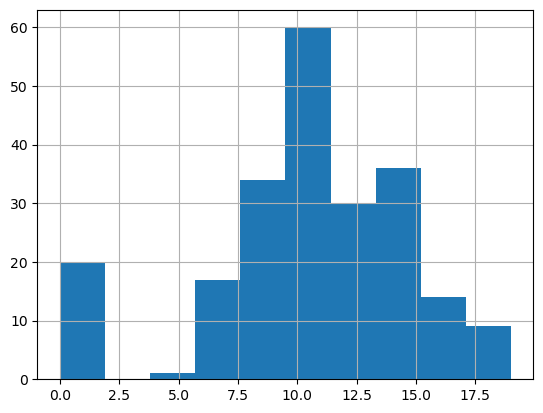

In [30]:
y_train.G3.hist()

In [31]:
# MAKE THE THING: create the model object
glm = TweedieRegressor(power=1, alpha=0)

#1. FIT THE THING: fit the model to training data
# We must specify the column in y_train, since we have converted it to a dataframe from a series!
glm.fit(X_train, y_train.G3)

#2. USE THE THING: make a prediction
y_train['G3_pred_glm'] = glm.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_glm) ** (1/2)

#4. REPEAT STEPS 2-3

# predict validate
y_validate['G3_pred_glm'] = glm.predict(X_validate)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_glm) ** (1/2)\

print(f"""RMSE for GLM using Tweedie, power=1 & alpha=0
_____________________
Training/In-Sample: {rmse_train}, 
Validation/Out-of-Sample:  {rmse_validate}
Difference:  {rmse_validate - rmse_train}""")

RMSE for GLM using Tweedie, power=1 & alpha=0
_____________________
Training/In-Sample: 2.1831609449715192, 
Validation/Out-of-Sample:  2.383365720198102
Difference:  0.20020477522658275


In [32]:
#Append
metric_df = metric_df.append({
    'model': 'glm_poisson', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    'R2_validate':explained_variance_score(y_validate.G3,
                                           y_validate.G3_pred_glm)
    }, ignore_index=True)

<div style="border: 1px solid black; border-radius: 3px; background: green; padding: .5em 1em;">
    <p style="font-size: 1.3em; font-weight: bold">Mini Exercise</p>
    <ol>
        <li><code>Use a different power</code> with the generalized linear model to try the fit of a different distribution based on the above code.</li>
        <li>Does it seem to perform better or worse than the first pick? Could you see why it may change? What does "power" mean here?</li>
    </ol>
</div>

In [33]:
# MAKE THE THING: create the model object
glmN = TweedieRegressor(power=0, alpha=0)

#1. FIT THE THING: fit the model to training data
# We must specify the column in y_train, since we have converted it to a dataframe from a series!
glmN.fit(X_train, y_train.G3)

#2. USE THE THING: make a prediction
y_train['G3_pred_glmN'] = glmN.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_glmN) ** (1/2)

#4. REPEAT STEPS 2-3

# predict validate
y_validate['G3_pred_glmN'] = glmN.predict(X_validate)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_glmN) ** (1/2)\

print(f"""RMSE for glm using Tweedie, power=0 & alpha=0
_____________________
Training/In-Sample: {rmse_train}, 
Validation/Out-of-Sample:  {rmse_validate}
Difference:  {rmse_validate - rmse_train}""")

RMSE for glm using Tweedie, power=0 & alpha=0
_____________________
Training/In-Sample: 1.7503548249715561, 
Validation/Out-of-Sample:  2.1265389095085196
Difference:  0.3761840845369635


In [34]:
metric_df = metric_df.append({
    'model': 'glm_normal', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    'R2_validate':explained_variance_score(y_validate.G3,
                                           y_validate.G3_pred_glmN)
    }, ignore_index=True)

In [35]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,4.498926,4.578917,2.220446e-16
1,OLS Regressor,1.750355,2.126408,7.768072e-01
2,lasso_alpha0.01,1.809016,2.074995,7.874654e-01
3,glm_poisson,2.183161,2.383366,7.198167e-01
4,glm_normal,1.750355,2.126539,7.767813e-01


___
### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

1. **Create** the new features, based on value indicated for **degree** for *train*, *validate* & *test*. 
- MAKE the thing
- FIT the thing
- USE (transform) the thing

2. Fit the Linear Regression model

3. Predict using the transformed (squared or cubed, e.g.) features 

4. Evaluate using RMSE

5. **Repeat** predictions and evaluation for `validation`.

6. **Compare** RMSE `train` vs. `validation`. Overfitting?

#### **Polynomial Features**
What does a polynomial look like when graphed on a coordinate plane? Well it depends on
- The intercept
- The coefficients

Interact with the following <a href="https://www.desmos.com/calculator/m44gdvrrhb"> graphing calculator</a>


In [36]:
#1. Create the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2) #quadratic aka x-squared

#1. Fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

#1. Transform X_validate_scaled & X_test_scaled 
X_validate_degree2 = pf.fit_transform(X_validate)
X_test_degree2 = pf.fit_transform(X_test)


#### **LinearRegression**

In [37]:
#2.1 MAKE THE THING: create the model object
lm2 = LinearRegression()

#2.2 FIT THE THING: fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.G3)

#3. USE THE THING: predict train
y_train['G3_pred_lm2'] = lm2.predict(X_train_degree2)

#4. Evaluate: rmse
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lm2) ** (1/2)

#4. REPEAT STEPS 3-4

# predict validate
y_validate['G3_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lm2) ** 0.5

print(f"""RMSE for Polynomial Model, degrees=2
_____________________________________________
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample:  {rmse_validate}""")

RMSE for Polynomial Model, degrees=2
_____________________________________________
Training/In-Sample:  1.0440447820961476 
Validation/Out-of-Sample:  3.4223421545589923


In [38]:
#Append
metric_df = metric_df.append({
    'model': 'quadratic', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    'R2_validate':explained_variance_score(y_validate.G3,
                                           y_validate.G3_pred_lm2)
    }, ignore_index=True)

In [39]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,4.498926,4.578917,2.220446e-16
1,OLS Regressor,1.750355,2.126408,7.768072e-01
2,lasso_alpha0.01,1.809016,2.074995,7.874654e-01
3,glm_poisson,2.183161,2.383366,7.198167e-01
4,glm_normal,1.750355,2.126539,7.767813e-01
5,quadratic,1.044045,3.422342,4.295427e-01


___
## Evaluate

##### **Plotting Actual vs. Predicted Values**

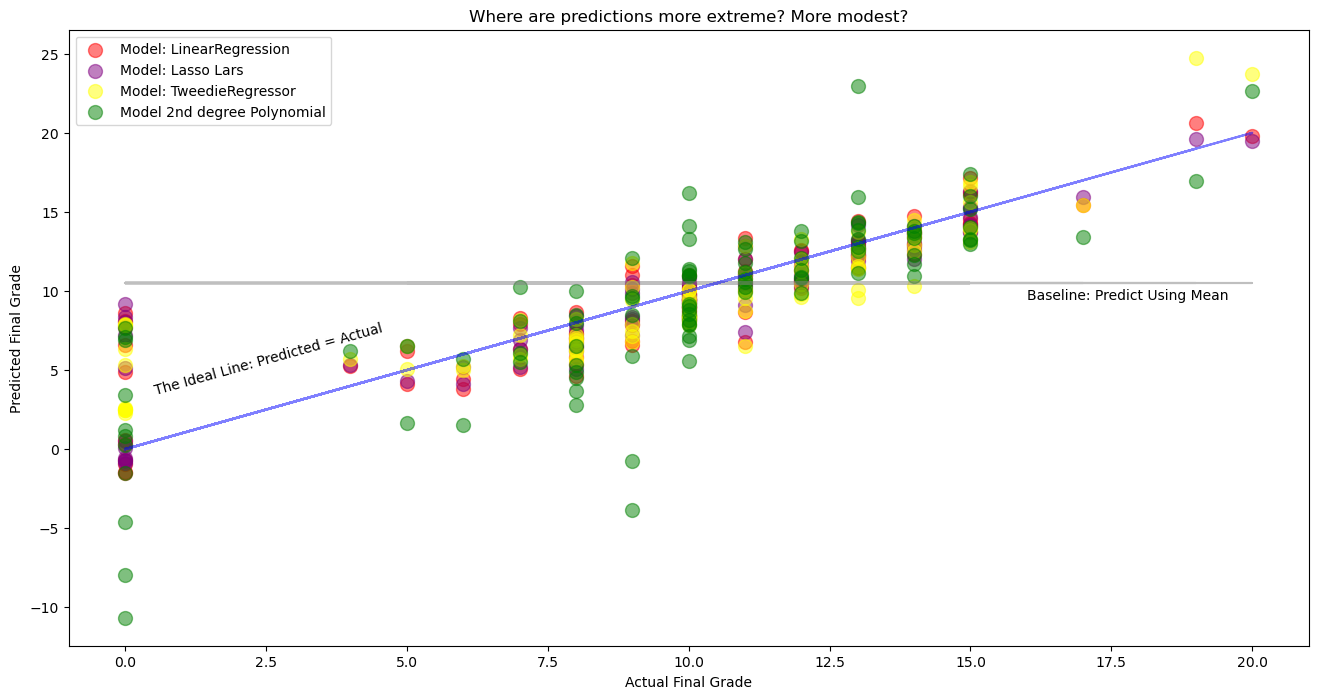

In [40]:
plt.figure(figsize=(16,8))
#actual vs mean
plt.plot(y_validate.G3, y_validate.G3_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))

#actual vs. actual
plt.plot(y_validate.G3, y_validate.G3, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

#actual vs. LinearReg model
plt.scatter(y_validate.G3, y_validate.G3_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
#actual vs. LassoLars model
plt.scatter(y_validate.G3, y_validate.G3_pred_lars, 
            alpha=.5, color="purple", s=100, label="Model: Lasso Lars")
#actual vs. Tweedie/GenLinModel
plt.scatter(y_validate.G3, y_validate.G3_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
##actual vs. PolynomReg/Quadratic
plt.scatter(y_validate.G3, y_validate.G3_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
plt.show()

<AxesSubplot:>

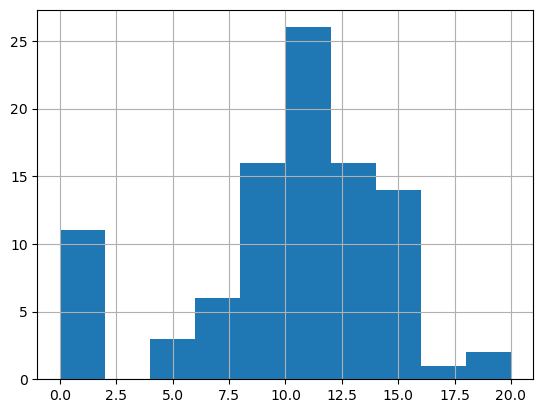

In [41]:
y_validate.G3.hist()

##### **Residual Plots: Plotting the Errors in Predictions**

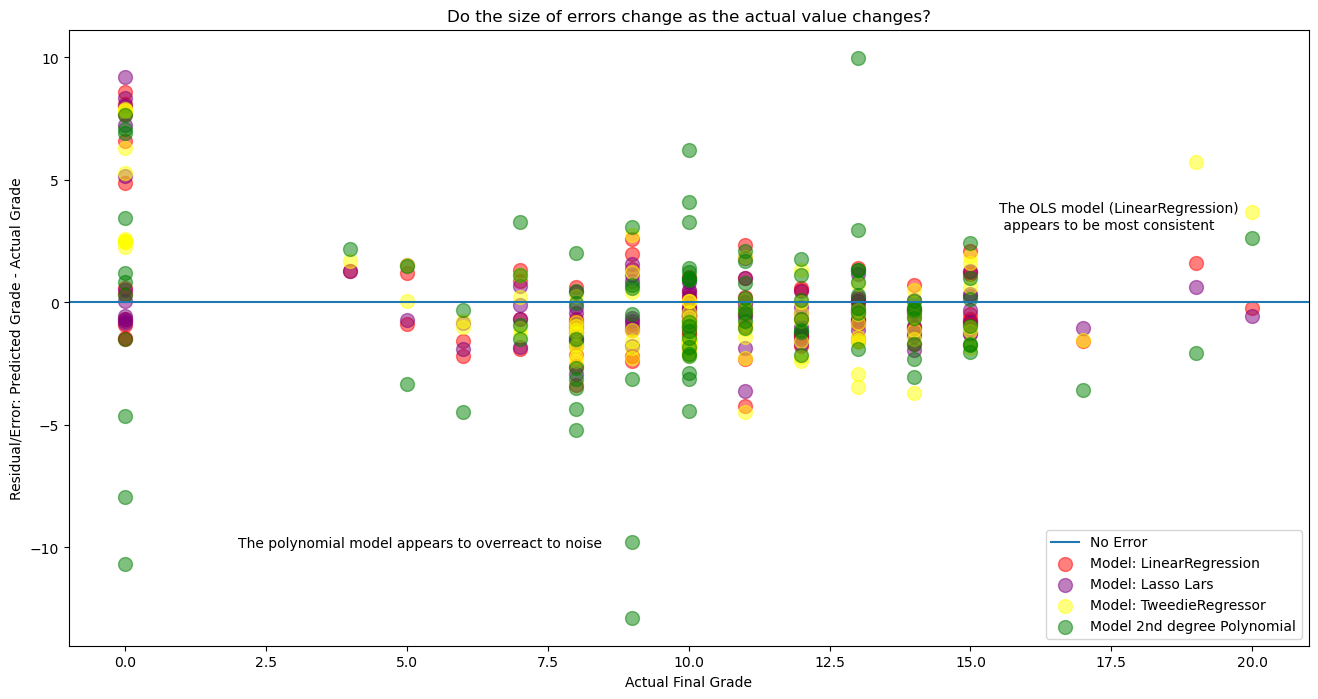

In [42]:
# y_validate.head()
plt.figure(figsize=(16,8))

plt.axhline(label="No Error")


plt.scatter(y_validate.G3, y_validate.G3_pred_lm - y_validate.G3 , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.G3, y_validate.G3_pred_lars - y_validate.G3 , 
            alpha=.5, color="purple", s=100, label="Model: Lasso Lars")
plt.scatter(y_validate.G3, y_validate.G3_pred_glm - y_validate.G3, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.G3, y_validate.G3_pred_lm2 - y_validate.G3, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")

plt.legend(loc=4)
plt.xlabel("Actual Final Grade")
plt.ylabel("Residual/Error: Predicted Grade - Actual Grade")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

##### **Histograms**

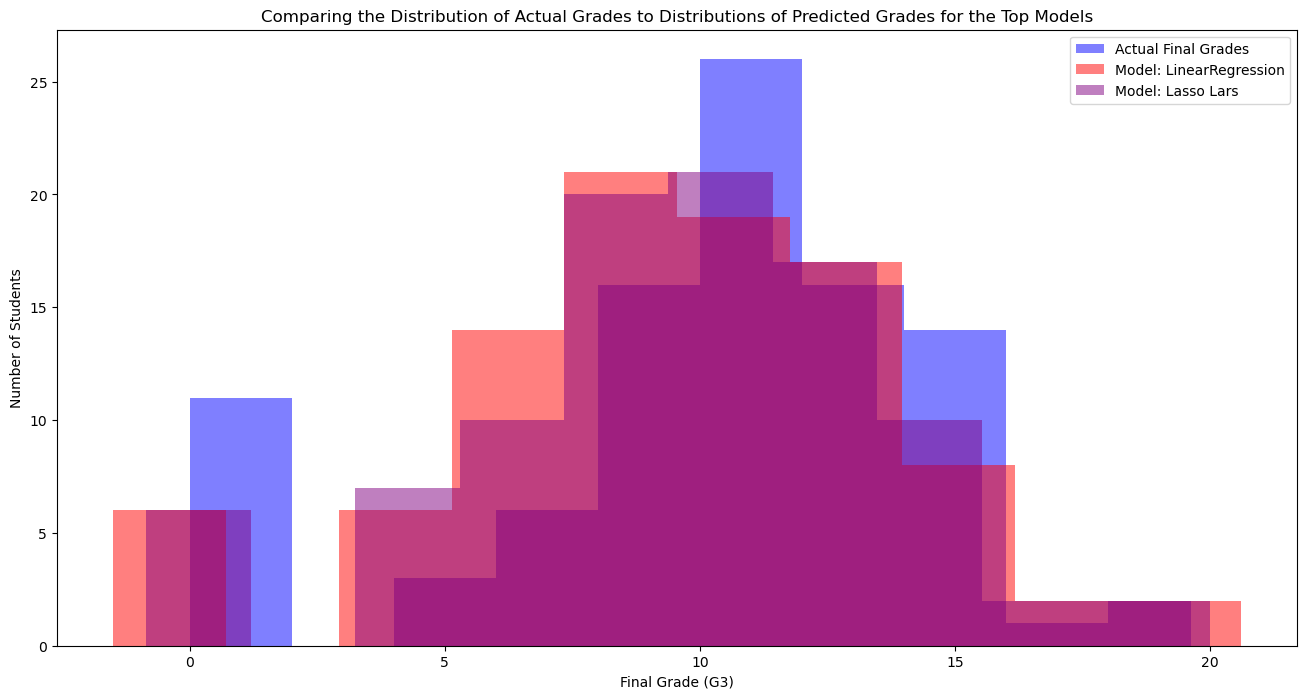

In [43]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))

plt.hist(y_validate.G3, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_validate.G3_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.G3_pred_lars, color='purple', alpha=.5, label="Model: Lasso Lars")
#plt.hist(y_validate.G3_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
#plt.hist(y_validate.G3_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")

plt.xlabel("Final Grade (G3)")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual Grades to Distributions of Predicted Grades for the Top Models")
plt.legend()
plt.show()

In [44]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,4.498926,4.578917,2.220446e-16
1,OLS Regressor,1.750355,2.126408,7.768072e-01
2,lasso_alpha0.01,1.809016,2.074995,7.874654e-01
3,glm_poisson,2.183161,2.383366,7.198167e-01
4,glm_normal,1.750355,2.126539,7.767813e-01
5,quadratic,1.044045,3.422342,4.295427e-01


## **Model Selection & Out-of-Sample Evaluation**

Model selected: lars (using Lasso lars with alpha = 0.01)

In [49]:
# Convert y_test Series to a df
y_test = pd.DataFrame(y_test)

# USE THE THING: predict on test
y_test['G3_pred_lars']=lars.predict(X_test)

# Evaluate: rmse
rmse_test = mean_squared_error(y_test.G3, y_test.G3_pred_lars)**.5


print(f"""RMSE for Lasso Lars Alpha=0.01
_____________________________________________      
Out-of-Sample Performance: {rmse_test}
Baseline: {metric_df.RMSE_train[0]}""")

RMSE for Lasso Lars Alpha=0.01
_____________________________________________      
Out-of-Sample Performance: 1.8868851165124216
Baseline: 4.498925523895268


In [46]:
y_train.max()

G3                19.000000
G3_pred_mean      10.524887
G3_pred_median    11.000000
G3_pred_lm        20.124513
G3_pred_lars      19.510665
G3_pred_lars7     10.524887
G3_pred_glm       23.953088
G3_pred_glmN      20.123028
G3_pred_lm2       19.374702
dtype: float64

In [47]:
lm_base_ratio = (rmse_test/metric_df.RMSE_train[0])*100

In [50]:
print(f"""Lasso Lars Alpha=0.01 Model decreased errors by {round(100-lm_base_ratio,2)}%""")

Lasso Lars Alpha=0.01 Model decreased errors by 58.06%
